# 10.9 Lab: Deep Learning

Imports

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [3]:
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
from torchvision.io import read_image

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [5]:
# from pytorch_lightning.utilities.seed import seed_everything # OLD
from lightning_fabric.fabric import seed_everything
seed_everything(0, workers=True)
# torch.use_deterministic_algorithms(mode=True, warn_only=True)

Seed set to 0


0

In [6]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

In [7]:
from ISLP.torch import SimpleModule, SimpleDataModule, ErrorTracker, rec_num_workers

In [8]:
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

In [9]:
from glob import glob
import json

## 10.9.1 Single Layer Network on Hitters Data

In [10]:
Hitters = load_data("Hitters").dropna()

In [11]:
model = MS(Hitters.columns.drop("Salary"), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters["Salary"].to_numpy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=1/3, random_state=1)

### Linear Models

In [13]:
hit_lm = LinearRegression().fit(X_train, y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - y_test).mean()

259.7152883314631

In [14]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[("scaler", scaler),
                                 ("lasso", lasso)])

In [15]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(y_train - y_train.mean())).max() / n
param_grid = {"alpha": np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

In [16]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring="neg_mean_absolute_error")
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [17]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - y_test).mean()

257.23820107995

### Specifying a network: Classes and Inheritance

In [18]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [19]:
hits_model = HittersModel(X.shape[1])

In [20]:
summary(hits_model,
        input_size=X_train.shape,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [21]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, y_train_t)

In [22]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, y_test_t)

In [23]:
max_workers = rec_num_workers()

In [24]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_workers),
                          validation=hit_test)

In [25]:
hit_module = SimpleModule.regression(hits_model,
                                     metrics={"mae":MeanAbsoluteError()})

In [26]:
hit_logger = CSVLogger("logs", name="hitters")

In [27]:
hit_trainer = Trainer(max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 51.90it/s, v_num=3]            

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 46.70it/s, v_num=3]


In [28]:
hit_trainer.test(hit_module, datamodule=hit_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 174.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               123543.3125
        test_mae            248.27792358398438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 123543.3125, 'test_mae': 248.27792358398438}]

In [29]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [30]:
hit_results

,train_mae_step,step,epoch,valid_mae,valid_loss,train_loss,train_mae_epoch,test_loss,test_mae
0,331.035126,4,0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5,0,237.721832,143938.828125,NaN,NaN,NaN,NaN
2,NaN,5,0,NaN,NaN,811154.375000,552.164978,NaN,NaN
3,228.919968,9,1,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,11,1,239.368225,140019.484375,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
156,265.289673,294,49,NaN,NaN,NaN,NaN,NaN,NaN
157,210.600296,299,49,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,299,49,248.277924,123543.312500,NaN,NaN,NaN,NaN
159,NaN,299,49,NaN,NaN,137719.765625,252.673508,NaN,NaN


In [31]:
def summary_plot(results,
                 ax,
                 col="loss",
                 valid_legend="Validation",
                 training_legend="Training",
                 ylabel="Loss",
                 fontsize=20):
   for (column, 
         color,
         label) in zip([f"train_{col}_epoch",
                        f"valid_{col}"],
                        ["black",
                         "red"],
                         [training_legend,
                          valid_legend]):
        results.plot(x="epoch",
                     y=column,
                     label=label,
                     marker="o",
                     color=color,
                     ax=ax)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
   return ax

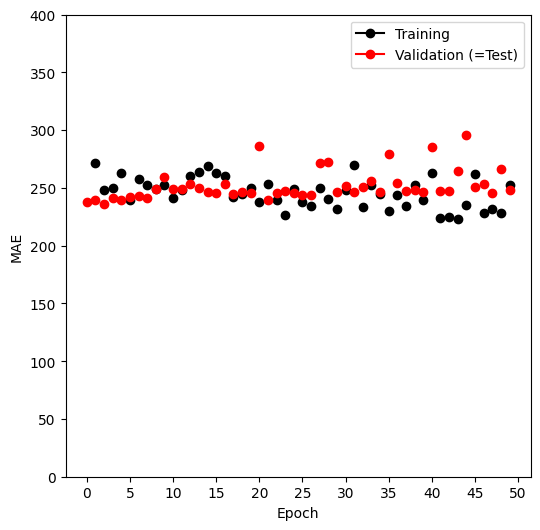

In [32]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col="mae",
                  ylabel="MAE",
                  valid_legend="Validation (=Test)")
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [33]:
hits_model.eval()
preds = hit_module(X_test_t)
torch.abs(y_test_t - preds).mean()

tensor(248.2779, grad_fn=<MeanBackward0>)

### Cleanup

In [34]:
del(Hitters,
    hits_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    y_test, y_train,
    X_test_t, y_test_t,
    hit_trainer, hit_module)

## 10.9.2 Multilayer Network on MNIST Digit Data

In [35]:
(mnist_train,
 mnist_test) = [MNIST(root="data",
                      train=train,
                      download=True,
                      transform=ToTensor()) 
                      for train in [True, False]]
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_workers,
                            batch_size=256)

In [37]:
for idx, (X_, Y_) in enumerate(mnist_dm.train_dataloader()):
    print("X: ", X_.shape)
    print("Y: ", Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [38]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self._forward(x)

In [39]:
mnist_model = MNISTModel()

In [40]:
mnist_model(X_).size()

torch.Size([256, 10])

In [41]:
summary(mnist_model,
        input_data=X_,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [42]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger("logs", name="MNIST")

In [43]:
mnist_trainer = Trainer(max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 84.32it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 83.94it/s, v_num=2]


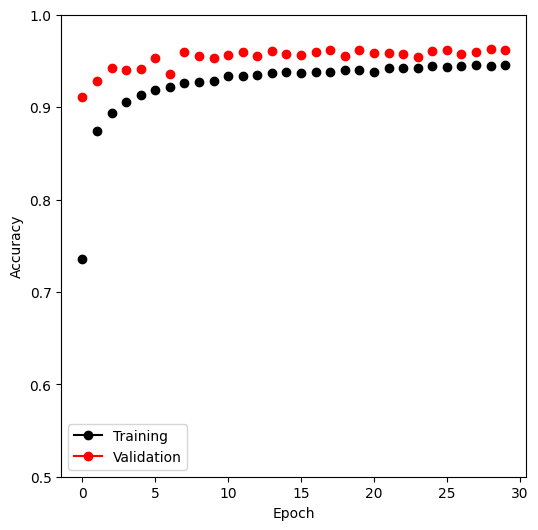

In [44]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col="accuracy",
             ylabel="Accuracy")
ax.set_ylim([0.5, 1])
ax.set_ylabel("Accuracy")
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [45]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 241.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9617999792098999
        test_loss           0.15074127912521362
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15074127912521362, 'test_accuracy': 0.9617999792098999}]

In [46]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger("logs", name="MNIST_MLR")

In [47]:
mlr_trainer = Trainer(max_epochs=30,
                      callbacks=[ErrorTracker()],
                      logger=mlr_logger)
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 89.19it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 88.66it/s, v_num=2]


In [48]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 192.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.920799970626831
        test_loss           0.33121004700660706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.33121004700660706, 'test_accuracy': 0.920799970626831}]

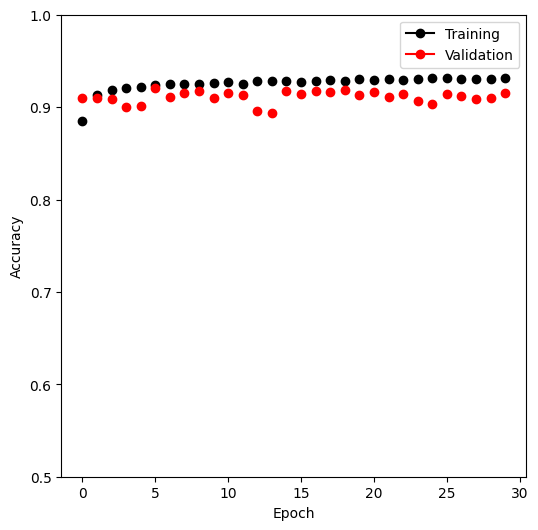

In [49]:
mnist_mlr_results = pd.read_csv(mlr_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_mlr_results,
             ax,
             col="accuracy",
             ylabel="Accuracy")
ax.set_ylim([0.5, 1])
ax.set_ylabel("Accuracy")
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [50]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer
    )

## 10.9.3 Convolutional Neural Networks

In [51]:
(cifar_train,
 cifar_test) = [CIFAR100(root="train",
                         train=train,
                         download=True)
                         for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [52]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                           torch.tensor(cifar_test.targets))

In [53]:
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_workers,
                            batch_size=128)

In [54]:
for idx, (X_, Y_) in enumerate(cifar_dm.train_dataloader()):
    print("X: ", X_.shape)
    print("Y: ", Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


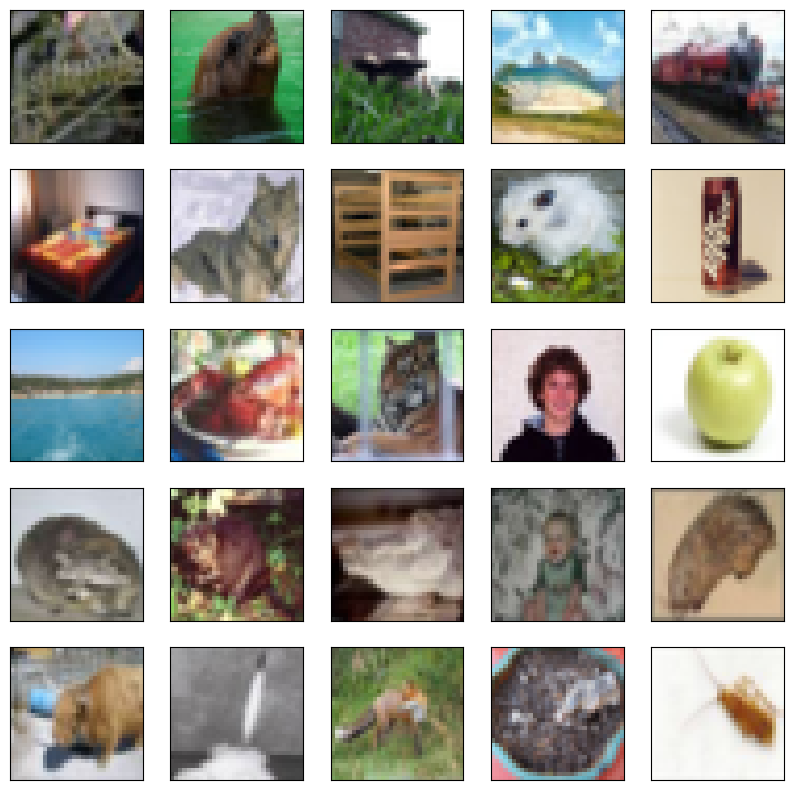

In [55]:
fig, axes = subplots(5, 5, figsize=(10, 10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5, 5))
for i in range(5):
    for j in range(5):
        idx = indices[i, j]
        axes[i, j].imshow(np.transpose(cifar_train[idx][0],
                                       [1, 2, 0]),
                                       interpolation=None)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

In [56]:
class BuildingBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3, 3),
                              padding="same")
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [57]:
class CifarModel(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [(3, 32),
                 (32, 64),
                 (64, 128),
                 (128, 256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [58]:
cifar_model = CifarModel()
summary(cifar_model,
        input_data=X_,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CifarModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [59]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                           optimizer=cifar_optimizer,
                                           num_classes=100)
cifar_logger = CSVLogger("logs", name="CIFAR100")

In [60]:
cifar_trainer = Trainer(max_epochs=30,
                        logger=cifar_logger,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | CifarModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 313/313 [00:05<00:00, 53.75it/s, v_num=1]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 313/313 [00:05<00:00, 53.45it/s, v_num=1]


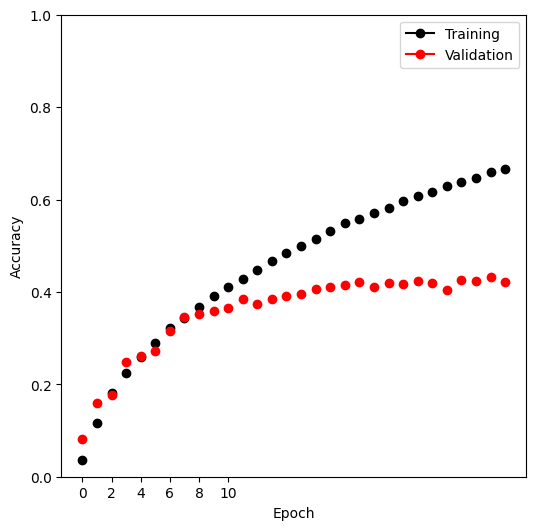

In [61]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results,
             ax,
             col="accuracy",
             ylabel="Accuracy")
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 1]);

In [62]:
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 194.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.42559999227523804
        test_loss           2.4300601482391357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.4300601482391357, 'test_accuracy': 0.42559999227523804}]

### Hardware Acceleration

In [63]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to("cuda")
    cifar_trainer_cuda = Trainer(accelerator="cuda",
                                 max_epochs=30)
    cifar_trainer_cuda.fit(cifar_module,
                           datamodule=cifar_dm)
    cifar_trainer_cuda.test(cifar_module,
                            datamodule=cifar_dm)
except:
    pass

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/adarsh/.pyenv/versions/3.10.12/envs/islp/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | CifarModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-tr

Epoch 29: 100%|██████████| 313/313 [00:05<00:00, 60.09it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 313/313 [00:05<00:00, 59.80it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 214.30it/s]


## 10.9.4 Using Pretrained CNN Models

In [64]:
resize = Resize((232, 232))
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225])
imgfiles = sorted([f for f in glob("book_images/*")])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

/home/adarsh/.pyenv/versions/3.10.12/envs/islp/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([5, 3, 224, 224])

In [65]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [66]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [67]:
img_preds = resnet_model(imgs)

In [68]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:, None]

In [69]:
labs = json.load(open("imagenet_class_index.json"))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                             labs.items()],
                             columns=["idx", "label"])
class_labels = class_labels.set_index("idx")
class_labels = class_labels.sort_index()

In [70]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df["prob"] = img_probs[i]
    img_df = img_df.sort_values(by="prob", ascending=False)[:3]
    print(f"Image: {imgfile}")
    print(img_df.reset_index().drop(columns=["idx"]))

Image: book_images/Cape_Weaver.jpg
       label      prob
0    jacamar  0.278434
1  bee_eater  0.047995
2     bulbul  0.039502
Image: book_images/Hawk_Fountain.jpg
            label      prob
0  great_grey_owl  0.281774
1            kite  0.042421
2        fountain  0.029358
Image: book_images/Hawk_cropped.jpg
    label      prob
0    kite  0.297028
1     jay  0.125653
2  magpie  0.015670
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.150388
1         Shih-Tzu  0.129438
2  Tibetan_terrier  0.103615
Image: book_images/Sleeping_Cat.jpg
       label      prob
0      tabby  0.172462
1  tiger_cat  0.110840
2    doormat  0.089069


In [71]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)

## 10.9.5 IMDB Document Classification

In [72]:
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root="data/IMDB")
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [73]:
lookup = load_lookup(root="data/IMDB")
" ".join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

In [74]:
max_workers = 10
(imdb_train,
 imdb_test) = load_tensor(root="data/IMDB")
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_workers),
                           batch_size=512)

In [75]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

In [76]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (G): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [77]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(imdb_model,
                                                 optimizer=imdb_optimizer)

In [78]:
imdb_logger = CSVLogger("logs", name="IMDB")
imdb_trainer = Trainer(max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/IMDB
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 160 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)


/home/adarsh/.pyenv/versions/3.10.12/envs/islp/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 45/45 [00:01<00:00, 37.83it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 45/45 [00:01<00:00, 37.40it/s, v_num=0]


In [79]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 57.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8450000286102295
        test_loss           1.0232608318328857
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0232608318328857, 'test_accuracy': 0.8450000286102295}]

### Comparison to Lasso

In [80]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root="data/IMDB")

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [81]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

In [82]:
logit = LogisticRegression(penalty="l1",
                           C=1/lam_max,
                           solver="liblinear",
                           warm_start=True,
                           fit_intercept=True)

In [83]:
coefs = []
intercepts = []
for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [84]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [86]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
    data_,
    color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ["Training", "Validation", "Test"],
                    ["black", "red", "blue"]):
    linpred_ = X_ * coefs.T + intercepts[None, :]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 ".--",
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r"$-\log(\lambda)$", fontsize=20)
axes[0].set_ylabel("Accuracy", fontsize=20)

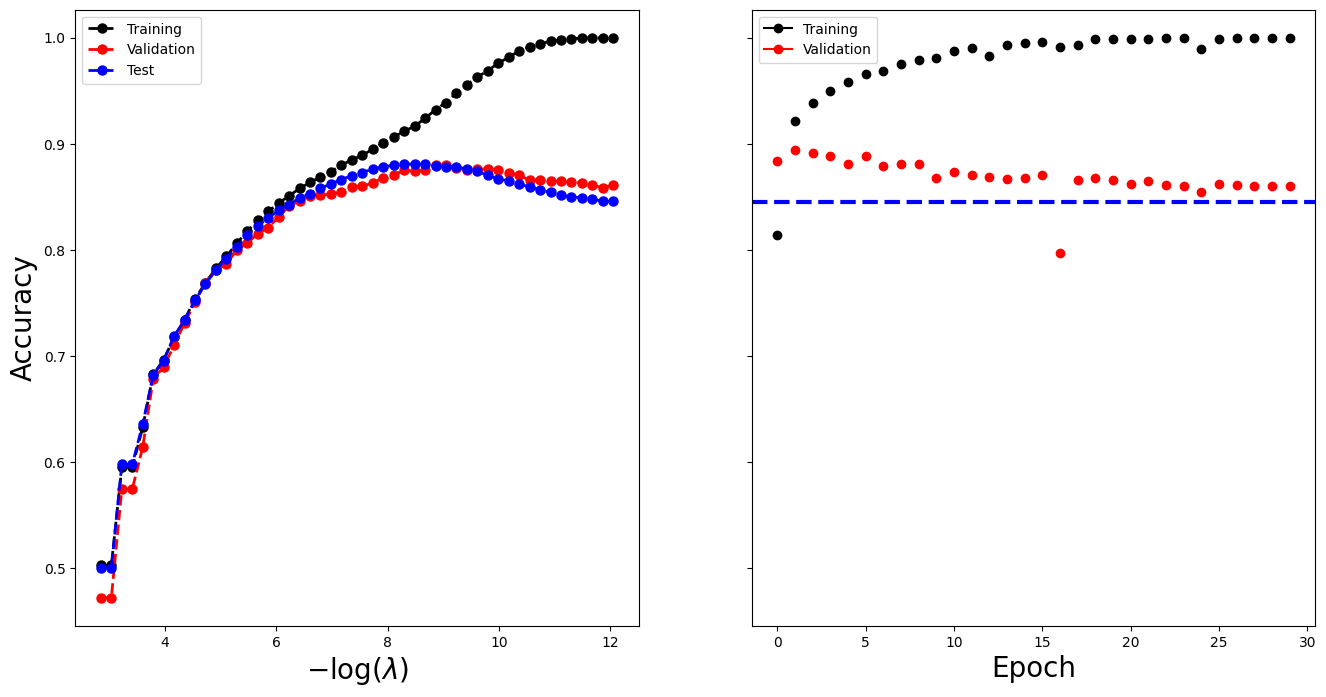

In [88]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col="accuracy",
             ylabel="Accuracy")
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel("Accuracy", fontsize=20)
axes[1].set_xlabel("Epoch", fontsize=20)
axes[1].axhline(test_results[0]["test_accuracy"],
                color="blue",
                linestyle="--",
                linewidth=3)
fig

In [89]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## 10.9.6 Recurrent Neural Networks

### Sequential Models for Document Classification

In [90]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_workers))